Building a speech recognition model to recognize one second audio clip as "down", "go", "left", "no", "right", "stop", "up" and "yes"

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Preparing the dataset and extracting the labeled commands: An audio dataset of spoken words designed to help train and evaluate keyword spotting systems

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

182083584/182082353 [==============================] - 2s 0us/step
Commands: ['go' 'down' 'stop' 'up' 'yes' 'left' 'no' 'right']


Extract the audio files into a list and shuffle it.

In [3]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/325a0c39_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 90:5:5 ratio, respectively.

In [4]:
train_files = filenames[:7200]
val_files = filenames[7200: 7200 + 400]
test_files = filenames[-400:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 7200
Validation set size 400
Test set size 400


Reading audio files and extract labels.
Note: the sample rate for this dataset is 16kHz



In [5]:
def decode_audio(audio_binary): 
  audio, _ = tf.audio.decode_wav(audio_binary) #returns the WAV-encoded audio as a Tensor and the sample rate.
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep) #path seperator /

  # use indexing here to enable this to work in a TensorFlow graph.
  return parts[-2] 

Get a tuple containing the audio and labels for supervised training.

In [6]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label
  

Build the training set and examine a few audio waveforms


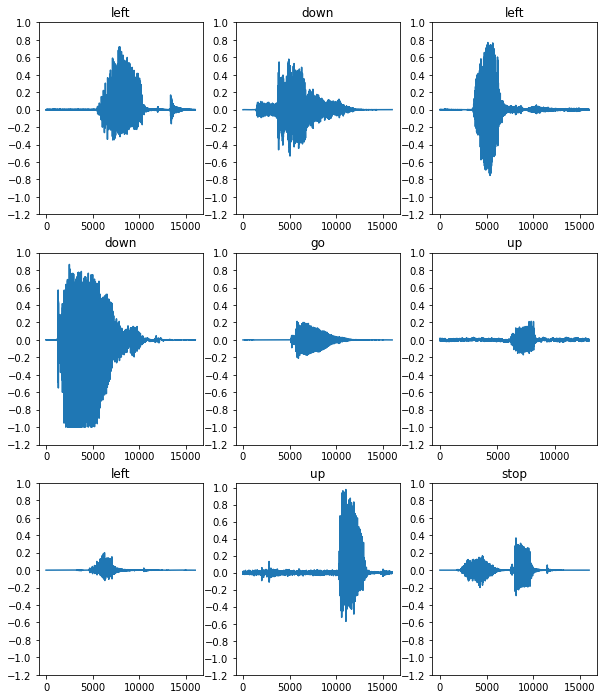

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
#get the train dataset in the form of objects (to construct a Dataset from data in memory)
files_ds = tf.data.Dataset.from_tensor_slices(train_files) 
# transform the train dataset into a new waveform Dataset and apply per-element transformations.
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


Converting the waveform into a spectrogram. (applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain). Returning a 2D tensor that we can run standard convolutions on

In [8]:
def get_spectrogram(waveform):
  # zero padding the audio clips that are shorter than one second (files with less than 16000 samples) to make the waveforms to have the same length
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Explore the data

In [9]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


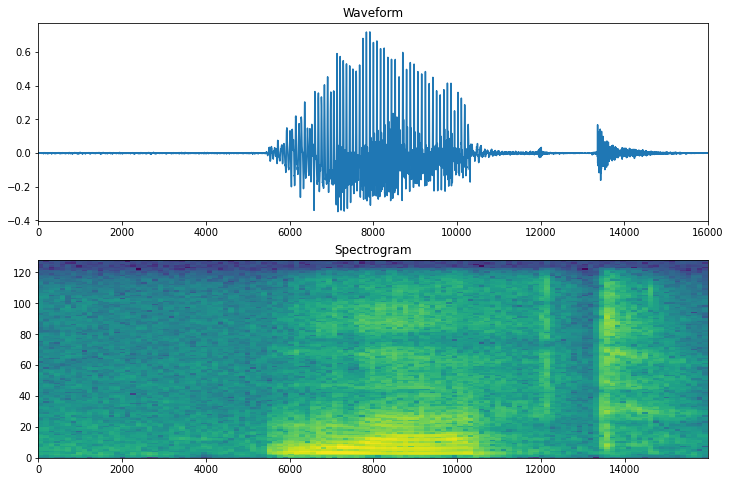

In [10]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs

In [11]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [12]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


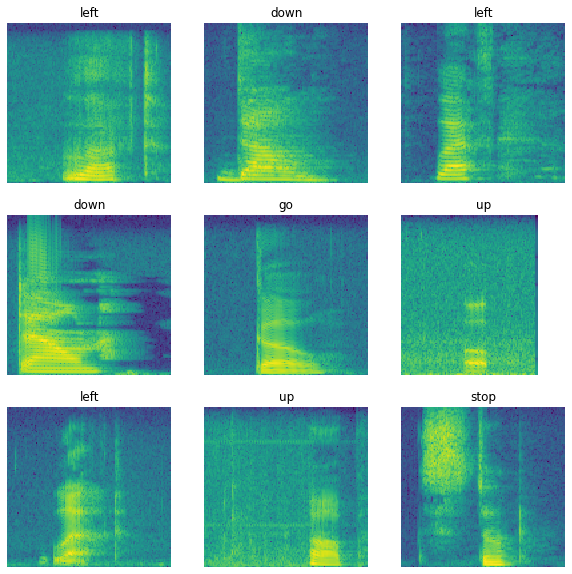

In [13]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

Preprocessing the validation and test sets.

In [14]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [15]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Build and train the model. The proposed model is a CNN to extract features and process the spectogram images.

In [16]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

#Cache and prefetch methods are used to reduce read latency while training the model 

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [17]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization() # to normalize each pixel in the image based on its mean and standard deviation
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x)) # compute mean and standard deviation



Input shape: (124, 129, 1)


In [18]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [19]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X



In [20]:
def ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [81]:
model = ResNet50(input_shape = input_shape, classes = num_labels)

In [82]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',factor=np.sqrt(0.1),patience = 5,min_lr=0.5e-6)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
model.summary()

In [83]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks= [reduce_lr] #tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), #patience = Number of epochs with no improvement after which training will be stopped
) #Assuming the goal of a training is to minimize the loss

Epoch 1/10
113/113 [==============================] - 31s 225ms/step - loss: 13.5075 - accuracy: 0.1319 - val_loss: 91.5506 - val_accuracy: 0.1025
Epoch 2/10
113/113 [==============================] - 25s 217ms/step - loss: 3.2696 - accuracy: 0.1429 - val_loss: 12.5318 - val_accuracy: 0.1450
Epoch 3/10
113/113 [==============================] - 24s 216ms/step - loss: 2.5809 - accuracy: 0.1990 - val_loss: 2.0344 - val_accuracy: 0.1650
Epoch 4/10
113/113 [==============================] - 25s 217ms/step - loss: 2.2756 - accuracy: 0.3643 - val_loss: 15.0179 - val_accuracy: 0.2775
Epoch 5/10
113/113 [==============================] - 25s 218ms/step - loss: 1.6265 - accuracy: 0.4935 - val_loss: 2.4174 - val_accuracy: 0.2575
Epoch 6/10
113/113 [==============================] - 25s 218ms/step - loss: 1.2219 - accuracy: 0.6133 - val_loss: 1.5744 - val_accuracy: 0.4675
Epoch 7/10
113/113 [==============================] - 25s 218ms/step - loss: 0.8857 - accuracy: 0.7211 - val_loss: 1.0589 - va

In [90]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

In [91]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks= [reduce_lr] #tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), #patience = Number of epochs with no improvement after which training will be stopped
) #Assuming the goal of a training is to minimize the loss

Epoch 1/10
113/113 [==============================] - 30s 235ms/step - loss: 1.0895 - accuracy: 0.8180 - val_loss: 5.4459 - val_accuracy: 0.7325
Epoch 2/10
113/113 [==============================] - 24s 215ms/step - loss: 0.3985 - accuracy: 0.8908 - val_loss: 0.7210 - val_accuracy: 0.8000
Epoch 3/10
113/113 [==============================] - 24s 213ms/step - loss: 0.2468 - accuracy: 0.9224 - val_loss: 0.3680 - val_accuracy: 0.8950
Epoch 4/10
113/113 [==============================] - 25s 218ms/step - loss: 0.1972 - accuracy: 0.9378 - val_loss: 0.3476 - val_accuracy: 0.8825
Epoch 5/10
113/113 [==============================] - 25s 218ms/step - loss: 0.1564 - accuracy: 0.9494 - val_loss: 0.3806 - val_accuracy: 0.8775
Epoch 6/10
113/113 [==============================] - 24s 216ms/step - loss: 0.1376 - accuracy: 0.9562 - val_loss: 0.3614 - val_accuracy: 0.8975
Epoch 7/10
113/113 [==============================] - 24s 216ms/step - loss: 0.1037 - accuracy: 0.9658 - val_loss: 0.3904 - val_ac

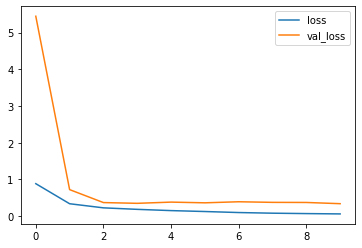

In [92]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Test the model on the test set

In [93]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 91%


Display confusion matrix to see how well the model did on each of the commands in the test set.

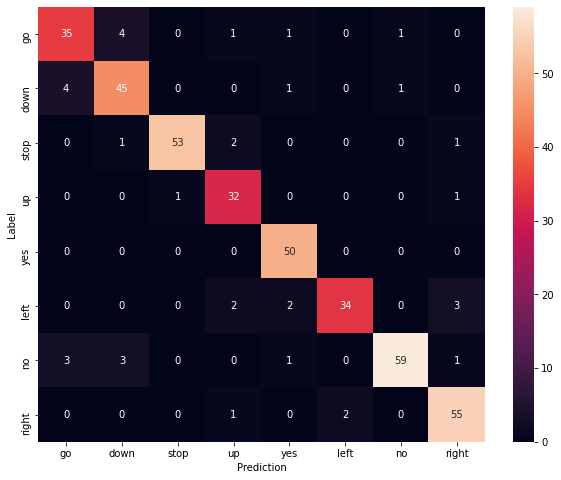

In [94]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Time to predict an input audio file (input audio file of someone saying "no.")

tf.Tensor([  1 124 129   1], shape=(4,), dtype=int32)


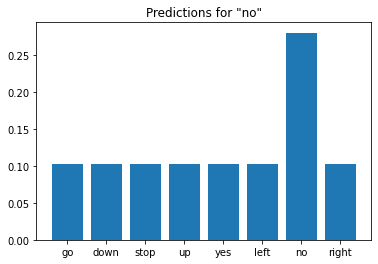

In [95]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav' #

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  print(tf.shape(spectrogram))
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

tf.Tensor([  1 124 129   1], shape=(4,), dtype=int32)


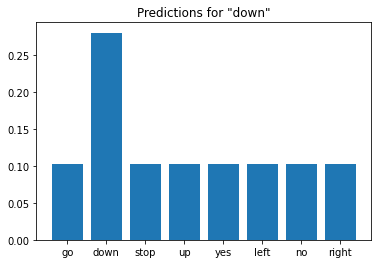

In [97]:
sample_file = data_dir/'down/004ae714_nohash_0.wav' #

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  print(tf.shape(spectrogram))
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

tf.Tensor([  1 124 129   1], shape=(4,), dtype=int32)


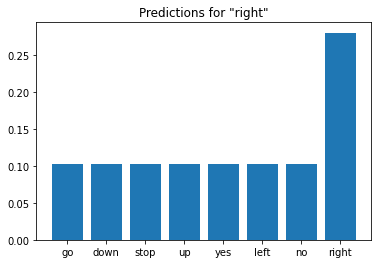

In [102]:
sample_file = data_dir/'right/012c8314_nohash_1.wav' #

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  print(tf.shape(spectrogram))
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()